# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

Максимальный балл за задание - 10.

## Часть 1. Обучение моделей классификации (5 баллов).

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

**A. (1 балл)** Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

**B. (1 балл)** Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

**C. (1 балл)** Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

**D. (1 балл)** Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

**E. (1 балл)** Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC?
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 916.4 kB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_auc_score, classification_report, recall_score
from sklearn.metrics import roc_curve, auc, precision_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [45]:
#your code here
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [46]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [5]:
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [6]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [47]:
X = df.drop('Churn', axis=1)
X.shape

(3333, 19)

In [48]:
y = df['Churn']
print(y.unique())
y = y.astype(int)
print(y.unique())

[False  True]
[0 1]


In [55]:
y.value_counts(normalize=True) # сильный дизбаланс

0    0.855086
1    0.144914
Name: Churn, dtype: float64

In [50]:
X_trainn, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

In [51]:
# будет использовать LOO
loo = LeaveOneOutEncoder(cols=['State', 'International plan', 'Voice mail plan'], sigma=1.5) # добавим гауссовский шум, как в гауссовком размытии
X_train = loo.fit_transform(X_trainn, y_train)
X_test = loo.transform(X_test, y_test)


In [52]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [54]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(X_train, y_train)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

print('Коэфы моделей')
print(lr.coef_)
print(svm.coef_)

print(f'F1_score методом логистической регресси на: {f1_score(y_test, lr.predict(X_test))}')
print(f'F1_score методом SVM (опорных векторов): {f1_score(y_test, svm.predict(X_test))}')
print(40*'-')
print(f'Accuracy методом логистической регрессии: {accuracy_score(y_test, lr.predict(X_test))}.')
print(f'Accuracy методом SVM (опорных векторов): {accuracy_score(y_test, svm.predict(X_test))}.')

Коэфы моделей
[[ 0.06865435  0.0528279   0.07448158  0.28736646 -0.0604286  -0.32429671
   0.36020288  0.02690136  0.36154905  0.17991906  0.04061795  0.17843501
   0.07729633  0.03544467  0.06047577  0.13600517 -0.21376767  0.17446895
   0.5628346 ]]
[[ 1.07763281e-05  2.17966630e-06 -1.08394128e-05  3.59719745e-05
   6.09031399e-06 -7.10581666e-05 -3.93690699e-03  2.98372515e-05
   3.91512614e-03 -2.40112962e-03 -9.53209173e-06  2.42624365e-03
   1.61906481e-02  1.09161102e-05 -1.62424607e-02 -1.86015817e-02
   1.72998783e-05  1.85966674e-02  1.46583357e-05]]
F1_score методом логистической регресси на: 0.12328767123287673
F1_score методом SVM (опорных векторов): 0.0
----------------------------------------
Accuracy методом логистической регрессии: 0.8465227817745803.
Accuracy методом SVM (опорных векторов): 0.8513189448441247.


в целом заметно, что свм показывает себя сильно хуже, коэффициенты практически нулевые
свм тут делает просто константное предсказание 0(долю в y)

теперь будем подбирать гиперпараметры гридом

In [14]:
lr_params = {
    'C': np.arange(0.1, 5, 0.1),
    'penalty': ['l1', 'l2'],
    'class_weight': ['None', 'balanced'], # данные не балансные поэтому лучше использовать бэлансд, ну он и выберется как  раз
    'tol': [0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(
    lr,
    lr_params,
    cv=4,
    scoring='f1'
)
grid_lr.fit(X_train, y_train)
print(f'F1_score методом логистической регресси с наилучшими параметрами на train: {f1_score(y_train, grid_lr.predict(X_train))},')
print(f'F1_score методом логистической регресси с наилучшими параметрами на test: {f1_score(y_test, grid_lr.predict(X_test))},')
print(f'ROC AUC методом методом логистической регресси с подбором параметров: {roc_auc_score(y_test, grid_lr.predict(X_test))},')
print(f'Accuracy методом методом логистической регресси с подбором параметров: {accuracy_score(y_test, grid_lr.predict(X_test))}.')
print('Используемые гиперпараметры:', grid_lr.best_params_)

F1_score методом логистической регресси с наилучшими параметрами на train: 0.4302134646962233,
F1_score методом логистической регресси с наилучшими параметрами на test: 0.4386792452830188,
ROC AUC методом методом логистической регресси с подбором параметров: 0.729225352112676,
Accuracy методом методом логистической регресси с подбором параметров: 0.7146282973621103.
Используемые гиперпараметры: {'C': 0.2, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga', 'tol': 0}


In [15]:
svm_params = {
    #'C': np.arange(0.1, 5, 0.1),
    'kernel': ['linear'],
    'class_weight': ['None', 'balanced'],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'decision_function_shape': ['ovo', 'ovr'],
    'probability': [True, False]
}

grid_svm = GridSearchCV(
    svm,
    svm_params,
    cv=4,
    scoring='f1'
)
grid_svm.fit(X_train, y_train)
print(f'F1_score методом SVM с наилучшими параметрами на train: {f1_score(y_train, grid_svm.predict(X_train))},')
print(f'F1_score методом SVM с наилучшими параметрами на test: {f1_score(y_test, grid_svm.predict(X_test))},')
print(f'ROC AUC методом методом SVM с подбором параметров: {roc_auc_score(y_test, grid_svm.predict(X_test))},')
print(f'Accuracy методом методом SVM с подбором параметров: {accuracy_score(y_test, grid_svm.predict(X_test))}.')
print('Используемые гиперпараметры:', grid_svm.best_params_)

F1_score методом SVM с наилучшими параметрами на train: 0.43216080402010054,
F1_score методом SVM с наилучшими параметрами на test: 0.42004773269689744,
ROC AUC методом методом SVM с подбором параметров: 0.7090640617900954,
Accuracy методом методом SVM с подбором параметров: 0.7086330935251799.
Используемые гиперпараметры: {'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'shrinking': True}


Лог регрессия: F1 получается 0,43(достаточно низко) и приблизительно равный на трейне и тесте => переобучения тут нет. Accuracy получается довольно низкий, модель посредственного качества. Можно лучше

SVM: F1 получается 0,43(достаточно низко) и приблизительно равный на трейне и тесте => переобучения тут нет. Accuracy 0.7 не слишком хорошо, модель посредственного качества. Тоже можно лучше

Теперь добавим полином

In [24]:
lr_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('logist_reg', LogisticRegression())
])

lr_pipe_params = {
    'logist_reg__C': [0.2],
    'logist_reg__class_weight': ['balanced'],
    'logist_reg__penalty': ['l1'],
    'logist_reg__solver': ['saga'],
    'poly__degree': np.arange(2, 4, 1)
}

grid_lr_pipe = GridSearchCV(
    lr_pipeline,
    lr_pipe_params,
    cv=4,
    scoring='f1'
)

grid_lr_pipe.fit(X_train, y_train)

print(f'F1_score методом логистической регресси с наилучшими параметрами на train: {f1_score(y_train, grid_lr_pipe.predict(X_train))},')
print(f'F1_score методом логистической регресси с наилучшими параметрами на test: {f1_score(y_test, grid_lr_pipe.predict(X_test))},')
print(f'ROC AUC методом методом логистической регресси с подбором параметров: {roc_auc_score(y_test, grid_lr_pipe.predict(X_test))},')
print(f'Accuracy методом логистической регресси с подбором параметра полиномиальности: {accuracy_score(y_test, grid_lr_pipe.predict(X_test))}.')
print('Используемые гиперпараметры:', grid_lr_pipe.best_params_)

F1_score методом логистической регресси с наилучшими параметрами на train: 0.7746650426309379,
F1_score методом логистической регресси с наилучшими параметрами на test: 0.5813148788927335,
ROC AUC методом методом логистической регресси с подбором параметров: 0.7816674238982281,
Accuracy методом логистической регресси с подбором параметра полиномиальности: 0.854916067146283.
Используемые гиперпараметры: {'logist_reg__C': 0.2, 'logist_reg__class_weight': 'balanced', 'logist_reg__penalty': 'l1', 'logist_reg__solver': 'saga', 'poly__degree': 3}


In [29]:
svm_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('svm', SVC())
])

svm_pipe_params = {
    'poly__degree': np.arange(2, 4, 1),
    'svm__class_weight': ['balanced'],
    'svm__decision_function_shape': ['ovo'],
    'svm__gamma': ['scale'],
    'svm__kernel': ['linear'],
    'svm__probability': [True],
    'svm__shrinking': [True]
}

grid_svm_pipe = GridSearchCV(
    svm_pipeline,
    svm_pipe_params,
    cv=4,
    scoring='f1'
)

grid_svm_pipe.fit(X_train, y_train)

print(f'F1_score методом SVM с наилучшими параметрами на train: {f1_score(y_train, grid_svm_pipe.predict(X_train))},')
print(f'F1_score методом SVM с наилучшими параметрами на test: {f1_score(y_test, grid_svm_pipe.predict(X_test))},')
print(f'ROC AUC методом SVM с подбором параметров: {roc_auc_score(y_test, grid_svm_pipe.predict(X_test))},')
print(f'Accuracy методом SVM с подбором параметра полиномиальности: {accuracy_score(y_test, grid_svm_pipe.predict(X_test))}.')
print('Используемые гиперпараметры:', grid_svm_pipe.best_params_)

F1_score методом SVM с наилучшими параметрами на train: 1.0,
F1_score методом SVM с наилучшими параметрами на test: 0.5037037037037037,
ROC AUC методом SVM с подбором параметров: 0.7192639709223081,
Accuracy методом SVM с подбором параметра полиномиальности: 0.8393285371702638.
Используемые гиперпараметры: {'poly__degree': 3, 'svm__class_weight': 'balanced', 'svm__decision_function_shape': 'ovo', 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'svm__probability': True, 'svm__shrinking': True}


обе модели выбирают степень полинома - 3
Лог регрессия: F1 сильно вырос с 0,43 до 0,77 и 0,58 на трейне и тесте соотвественно, поэтому тут есть переобучение. Accuracy высокий, модель хорошего качества

SVM: F1 на трейне получается 1, это не есть хорошо, модель сильно переобучена.
Однако accuracy тоже большой

Но из этих двух моделей лучшая это Логистическая регрессия

теперь проверим данные на мультиколлениарность

In [32]:
df_connected = pd.DataFrame(np.hstack((X_train, y_train.to_numpy().reshape(-1, 1))))
df_connected.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.454261,0.307547,-0.523841,0.241594,-0.865478,-0.594108,0.657988,1.422828,0.658473,0.341496,0.858571,0.341551,0.112577,-0.458061,0.112764,-1.327226,1.864980,-1.330691,1.877858,0.0
1,-0.379860,2.116044,1.716642,0.749533,-0.212241,-0.594108,0.626796,0.217507,0.627173,-0.813083,-0.800607,-0.812221,-1.227122,1.895488,-1.228899,-1.907951,2.274918,-1.908778,0.348522,0.0
2,-1.186594,0.307547,1.716642,0.023688,-0.348092,-0.594108,0.505699,0.619281,0.505212,1.070190,-1.001719,1.070128,0.189525,-0.662718,0.187301,-0.129481,-1.414524,-0.134186,-0.416146,0.0
3,0.922266,-1.373591,1.716642,-0.151493,1.038590,-0.594108,-2.418991,0.970833,-2.418617,-0.436038,1.160239,-0.435291,-0.962734,-0.202241,-0.961443,1.104560,1.045104,1.102651,-1.180813,1.0
4,-0.015938,-0.201889,-0.688929,0.483320,-0.439216,0.931842,-0.833714,0.217507,-0.834202,-0.756429,1.411630,-0.757061,-0.291898,-0.509225,-0.290612,0.560130,-1.004586,0.564896,1.877858,1.0


In [33]:
df_connected.corr().style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,-0.031190,0.056679,0.045109,-0.003279,0.000225,-0.017973,0.011020,-0.017965,0.026572,0.023504,0.026576,0.007633,0.026676,0.007632,0.014230,-0.000111,0.014248,0.036958,0.022369
1,-0.031190,1.000000,-0.019636,-0.009994,0.007437,-0.006992,0.005655,0.030380,0.005653,-0.004589,0.027043,-0.004579,-0.017001,-0.015728,-0.016998,-0.002258,0.019385,-0.002248,-0.022107,0.009665
2,0.056679,-0.019636,1.000000,0.050751,-0.003883,-0.018980,0.019972,-0.018315,0.019967,0.016565,-0.008359,0.016588,-0.013368,0.018275,-0.013396,-0.032231,-0.015306,-0.032407,0.018612,0.027230
3,0.045109,-0.009994,0.050751,1.000000,-0.002513,-0.018204,-0.003205,-0.017244,-0.003199,0.005896,0.010997,0.005879,-0.018335,0.016737,-0.018323,0.008214,-0.018706,0.008203,0.002587,0.130452
4,-0.003279,0.007437,-0.003883,-0.002513,1.000000,-0.173648,0.010960,-0.018554,0.010955,-0.017323,-0.006477,-0.017321,0.028221,0.010364,0.028223,0.016453,0.022574,0.016533,-0.017843,0.018872
5,0.000225,-0.006992,-0.018980,-0.018204,-0.173648,1.000000,0.013263,-0.005564,0.013258,0.028459,-0.007054,0.028471,-0.003861,0.010613,-0.003879,-0.003826,0.008484,-0.003818,0.003903,-0.076868
6,-0.017973,0.005655,0.019972,-0.003205,0.010960,0.013263,1.000000,0.009807,1.000000,0.004827,0.031647,0.004820,0.017320,0.038723,0.017285,-0.008829,0.008615,-0.008777,0.002031,0.219421
7,0.011020,0.030380,-0.018315,-0.017244,-0.018554,-0.005564,0.009807,1.000000,0.009809,-0.015668,0.002999,-0.015668,0.031654,-0.031719,0.031673,0.020069,0.018748,0.020218,-0.016304,0.008583
8,-0.017965,0.005653,0.019967,-0.003199,0.010955,0.013258,1.000000,0.009809,1.000000,0.004835,0.031647,0.004829,0.017323,0.038722,0.017288,-0.008830,0.008619,-0.008778,0.002024,0.219422
9,0.026572,-0.004589,0.016565,0.005896,-0.017323,0.028459,0.004827,-0.015668,0.004835,1.000000,-0.018373,1.000000,-0.018522,0.007546,-0.018529,0.007906,0.000420,0.007907,-0.004904,0.100968


In [43]:
print(f'корреляция равная 1 между {X_trainn.columns[8]} и {X_trainn.columns[6]}')
print(f'корреляция равная 1 между {X_trainn.columns[9]} и {X_trainn.columns[11]}')
print(f'корреляция равная 1 между {X_trainn.columns[14]} и {X_trainn.columns[12]}')
print(f'корреляция равная 1 между {X_trainn.columns[17]} и {X_trainn.columns[15]}')

корреляция равная 1 между Total day charge и Total day minutes
корреляция равная 1 между Total eve minutes и Total eve charge
корреляция равная 1 между Total night charge и Total night minutes
корреляция равная 1 между Total intl charge и Total intl minutes


In [44]:
X_new = X.drop(['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge'], axis=1, inplace=False)
X_new.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls
0,KS,128,415,No,Yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1
1,OH,107,415,No,Yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1
2,NJ,137,415,No,No,0,243.4,114,121.2,110,162.6,104,12.2,5,0
3,OH,84,408,Yes,No,0,299.4,71,61.9,88,196.9,89,6.6,7,2
4,OK,75,415,Yes,No,0,166.7,113,148.3,122,186.9,121,10.1,3,3


In [45]:
# снова LOO
X_trainn, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3)

loo_enc = LeaveOneOutEncoder(cols=['State', 'International plan', 'Voice mail plan'], sigma=1.5)
X_train = loo_enc.fit_transform(X_trainn, y_train)
X_test = loo_enc.transform(X_test, y_test)

In [54]:
lr_pipeline_nocorr = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('logist_reg', LogisticRegression())
])

lr_pipe_params_nocorr = {
    'logist_reg__C': [0.2],
    'logist_reg__class_weight': ['balanced'],
    'logist_reg__penalty': ['l1'],
    'logist_reg__solver': ['saga'],
    'poly__degree': np.arange(2, 4, 1)
}

grid_lr_pipe_nocorr = GridSearchCV(
    lr_pipeline_nocorr,
    lr_pipe_params_nocorr,
    cv=4,
    scoring='f1'
)

grid_lr_pipe_nocorr.fit(X_train, y_train)

print(f'F1_score методом логистической регресси с наилучшими параметрами на train без коррелирующих между собой признаков: {f1_score(y_train, grid_lr_pipe_nocorr.predict(X_train))},')
print(f'F1_score методом логистической регресси с наилучшими параметрами на test без коррелирующих между собой признаков: {f1_score(y_test, grid_lr_pipe_nocorr.predict(X_test))},')
print(f'ROC AUC методом методом логистической регресси с подбором параметров без коррелирующих между собой признаков: {roc_auc_score(y_test, grid_lr_pipe_nocorr.predict(X_test))},')
print(f'Accuracy методом логистической регресси с подбором параметра полиномиальности без коррелирующих между собой признаков: {accuracy_score(y_test, grid_lr_pipe_nocorr.predict(X_test))}.')
print('Используемые гиперпараметры:', grid_lr_pipe_nocorr.best_params_)

F1_score методом логистической регресси с наилучшими параметрами на train без коррелирующих между собой признаков: 0.7304347826086957,
F1_score методом логистической регресси с наилучшими параметрами на test без коррелирующих между собой признаков: 0.582857142857143,
ROC AUC методом методом логистической регресси с подбором параметров без коррелирующих между собой признаков: 0.7877359619111419,
Accuracy методом логистической регресси с подбором параметра полиномиальности без коррелирующих между собой признаков: 0.854.
Используемые гиперпараметры: {'logist_reg__C': 0.2, 'logist_reg__class_weight': 'balanced', 'logist_reg__penalty': 'l1', 'logist_reg__solver': 'saga', 'poly__degree': 3}


In [55]:
svm_pipeline_nocorr = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('svm', SVC())
])

svm_pipe_params_nocorr = {
    'poly__degree': np.arange(2, 4, 1),
    'svm__class_weight': ['balanced'],
    'svm__decision_function_shape': ['ovo'],
    'svm__gamma': ['scale'],
    'svm__kernel': ['linear'],
    'svm__probability': [True],
    'svm__shrinking': [True]
}

grid_svm_pipe_nocorr = GridSearchCV(
    svm_pipeline_nocorr,
    svm_pipe_params_nocorr,
    cv=4,
    scoring='f1'
)

grid_svm_pipe_nocorr.fit(X_train, y_train)

print(f'F1_score методом SVM с наилучшими параметрами на train без коррелирующих между собой признаков: {f1_score(y_train, grid_svm_pipe_nocorr.predict(X_train))},')
print(f'F1_score методом SVM с наилучшими параметрами на test без коррелирующих между собой признаков: {f1_score(y_test, grid_svm_pipe_nocorr.predict(X_test))},')
print(f'ROC AUC методом SVM с подбором параметров без коррелирующих между собой признаков: {roc_auc_score(y_test, grid_svm_pipe_nocorr.predict(X_test))},')
print(f'Accuracy методом SVM с подбором параметра полиномиальности без коррелирующих между собой признаков: {accuracy_score(y_test, grid_svm_pipe_nocorr.predict(X_test))}.')
print('Используемые гиперпараметры:', grid_svm_pipe_nocorr.best_params_)

F1_score методом SVM с наилучшими параметрами на train без коррелирующих между собой признаков: 1.0,
F1_score методом SVM с наилучшими параметрами на test без коррелирующих между собой признаков: 0.43333333333333335,
ROC AUC методом SVM с подбором параметров без коррелирующих между собой признаков: 0.6695057859016995,
Accuracy методом SVM с подбором параметра полиномиальности без коррелирующих между собой признаков: 0.83.
Используемые гиперпараметры: {'poly__degree': 3, 'svm__class_weight': 'balanced', 'svm__decision_function_shape': 'ovo', 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'svm__probability': True, 'svm__shrinking': True}


Результаты у логистической регрессии не сильно поменялись, однако результаты у svm стали чуть хуже и f1 на трейне не стал меньше 1

Поэтому тут можно сказать, что лучшая модель это модель логистической регрессии без коррелирующих признаков с параметрами модели: **{'logist_reg__C': 0.2, 'logist_reg__class_weight': 'balanced', 'logist_reg__penalty': 'l1', 'logist_reg__solver': 'saga', 'poly__degree': 3}**

удалил: 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge'

Можно нарисовать рок кривую для этой модельки

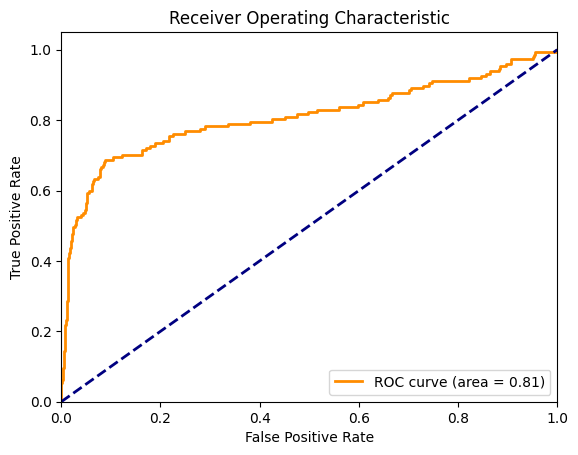

In [56]:
y_scores = grid_lr_pipe_nocorr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

у рок кривой изгиб получается не красивый, линия получается довольно пологой

## Часть 2. Оценка качества моделей классификации (5 баллов).

**Задание 0. (0.25 балла)** Закончите определения, начинающиеся так:

    * accuracy - это доля правильных ответов алгоритма по отношению ко всем полученным прогнозам
    
    * точность (precision) - это доля правильных ответов положительных классификаций из всех положительных, предсказанных моделью

    * полнота (recall) - это доля положительных классификаций из всех реальных положительных случаев
    
    * TPR - (тоже самое, что и полнота) это доля положительных классификаций из всех реальных положительных случаев
    
    
Продолжите определения прямо в этой ячейке.

_______________________________________________________________________________________________

В этой части вы будете работать с данными в задаче скоринга. За работу с этими данными можно получить **5 баллов.**

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные).
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [4]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [5]:
df.shape

(689, 21)

**Задание 1. (0.25 балла)** Проверьте target на сбалансированность по классам, сделайте вывод.

In [6]:
X = df.drop(['target'], axis=1)
y = df['target']
print(y.value_counts())
print(y.value_counts(normalize=True))

# таргет сбалансированна по классам

0    382
1    307
Name: target, dtype: int64
0    0.554427
1    0.445573
Name: target, dtype: float64


**Задание 2. (0.25 балла)** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [7]:
#your code here
print(f'Алгоритм 1 имеет Accuracy = {accuracy_score(y, X["pred1_classes"])}.')
print(f'Алгоритм 2 имеет Accuracy = {accuracy_score(y, X["pred2_classes"])}.')
print(f'Алгоритм 3 имеет Accuracy = {accuracy_score(y, X["pred3_classes"])}.')

# точность выше у второго, однако они все +- близко находятся друг к другу

Алгоритм 1 имеет Accuracy = 0.6618287373004355.
Алгоритм 2 имеет Accuracy = 0.6719883889695211.
Алгоритм 3 имеет Accuracy = 0.6400580551523948.


**Задание 3. (0.25 балла)** Теперь вычислите точность и полноту каждого из алгоритмов.

In [8]:
#your code here
print(f'Алгоритм 1 имеет Recall = {recall_score(y, X["pred1_classes"])}.')
print(f'Алгоритм 1 имеет Precision = {precision_score(y, X["pred1_classes"])}.')
print(f'Алгоритм 2 имеет Recall = {recall_score(y, X["pred2_classes"])}.')
print(f'Алгоритм 2 имеет Precision = {precision_score(y, X["pred2_classes"])}.')
print(f'Алгоритм 3 имеет Recall = {recall_score(y, X["pred3_classes"])}.')
print(f'Алгоритм 3 имеет Precision = {precision_score(y, X["pred3_classes"])}.')

Алгоритм 1 имеет Recall = 0.4364820846905538.
Алгоритм 1 имеет Precision = 0.6907216494845361.
Алгоритм 2 имеет Recall = 0.7296416938110749.
Алгоритм 2 имеет Precision = 0.6103542234332425.
Алгоритм 3 имеет Recall = 0.3485342019543974.
Алгоритм 3 имеет Precision = 0.6903225806451613.


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4. (0.5 балла)** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [9]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

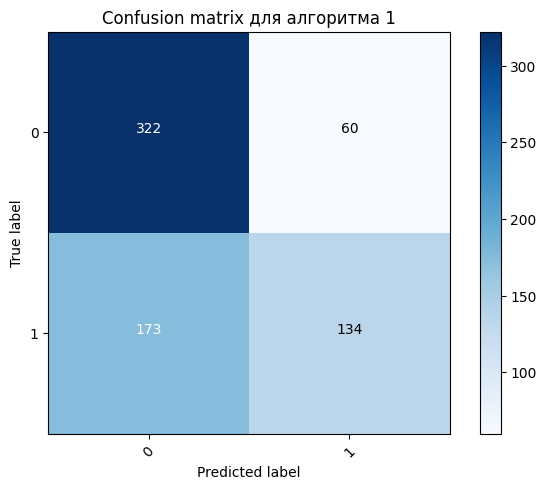

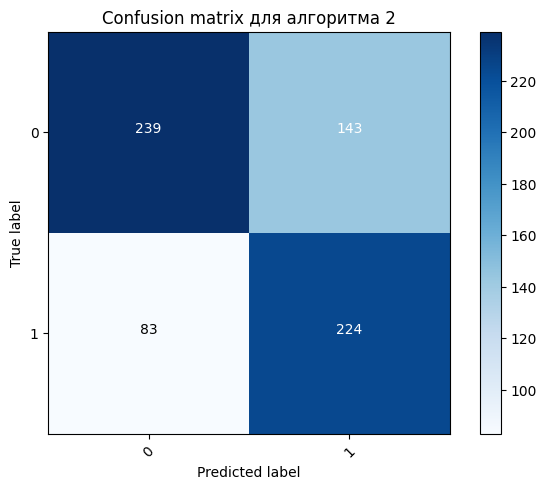

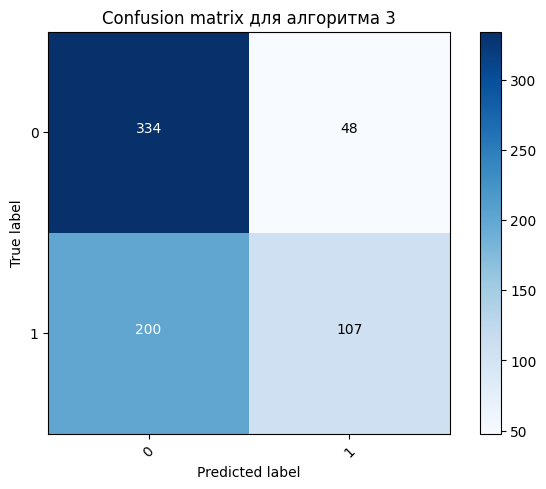

In [10]:
#your code here
for i in range(1, 4):
  cm = confusion_matrix(y, X[f'pred{i}_classes'])
  plot_confusion_matrix(cm, set(y), title=f'Confusion matrix для алгоритма {i}')
  plt.show()

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5. (0.5 балла)** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [16]:
%%time
# алогритм кстати получается очень медленным(( 15 секунд долго
#не придумал как оптимизировать, мб через функции было бы быстрее
y_newnew1 = []
recall = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred1_probs"][j] > i:
            y_newnew1.append(1)
        else:
            y_newnew1.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew1})) < 0.65:
        recall.append(0)
        y_newnew1 = []
    else:
        recall.append(recall_score(y, pd.DataFrame({'': y_newnew1})))
        y_newnew1 = []
    i_list.append(i)

if np.max(recall) > 0:
    print(f'Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен {max(recall)}, '
      f'порог вероятности равен {i_list[recall.index(max(recall))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred1_probs"][j] > i_list[recall.index(np.max(recall))]:
        y_newnew1.append(1)
    else:
        y_newnew1.append(0)

Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен 0.745928338762215, порог вероятности равен 0.359.
CPU times: user 10.4 s, sys: 51.7 ms, total: 10.4 s
Wall time: 12.8 s


In [13]:
y_newnew2 = []
recall = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred2_probs"][j] > i:
            y_newnew2.append(1)
        else:
            y_newnew2.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew2})) < 0.65:
        recall.append(0)
        y_newnew2 = []
    else:
        recall.append(recall_score(y, pd.DataFrame({'': y_newnew2})))
        y_newnew2 = []
    i_list.append(i)

if np.max(recall) > 0:
    print(f'Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен {np.max(recall)}, '
      f'порог вероятности равен {i_list[recall.index(np.max(recall))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred2_probs"][j] > i_list[recall.index(np.max(recall))]:
        y_newnew2.append(1)
    else:
        y_newnew2.append(0)

Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен 0.8469055374592834, порог вероятности равен 0.262.


In [15]:
y_newnew3 = []
recall = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred3_probs"][j] > i:
            y_newnew3.append(1)
        else:
            y_newnew3.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew3})) < 0.65:
        recall.append(0)
        y_newnew3 = []
    else:
        recall.append(recall_score(y, pd.DataFrame({'': y_newnew3})))
        y_newnew3 = []
    i_list.append(i)

if np.max(recall) > 0:
    print(f'Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен {np.max(recall)}, '
      f'порог вероятности равен {i_list[recall.index(np.max(recall))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred3_probs"][j] > i_list[recall.index(np.max(recall))]:
        y_newnew3.append(1)
    else:
        y_newnew3.append(0)

Данная модель ни при каком шаге не даёт accuracy >= 0.65.


**Задание 6. (0.5 балла)** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

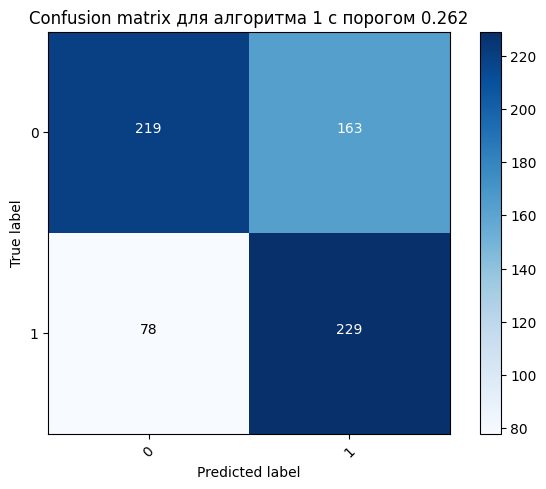

In [17]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew1})), set(y), title='Confusion matrix для алгоритма 1 c порогом 0.262')

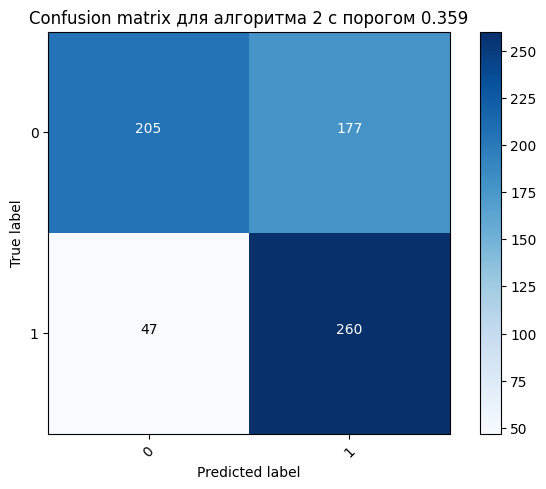

In [18]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew2})), set(y), title='Confusion matrix для алгоритма 2 c порогом 0.359')

**Выводы:**
Начнём с 3 модели. Она не справилась с задачей совсем, так как при любом пороге Accuracy было меньше 0.65.

1 модель дала Recall = 0.746, тогда как модель номер 2 выдала Recall = 0.847, что больше, чем у первой. Это значит, что модель 2 лучше всех выполняет задачу максимизации выдачи кредитов тем людям, которые смогут их вернуть

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги).
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7. (0.5 балла)** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

In [22]:
y_newnew11 = []
precision = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred1_probs"][j] > i:
            y_newnew11.append(1)
        else:
            y_newnew11.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew11})) < 0.65:
        precision.append(0)
        y_newnew11 = []
    else:
        precision.append(precision_score(y, pd.DataFrame({'': y_newnew11})))
        y_newnew11 = []
    i_list.append(i)

if np.max(precision) > 0:
    print(f'Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен {max(precision)}, '
      f'порог вероятности равен {i_list[precision.index(np.max(precision))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred1_probs"][j] > i_list[precision.index(np.max(precision))]:
        y_newnew11.append(1)
    else:
        y_newnew11.append(0)


Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен 0.7371794871794872, порог вероятности равен 0.54.


In [23]:
y_newnew22 = []
precision = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred2_probs"][j] > i:
            y_newnew22.append(1)
        else:
            y_newnew22.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew22})) < 0.65:
        precision.append(0)
        y_newnew22 = []
    else:
        precision.append(precision_score(y, pd.DataFrame({'': y_newnew22})))
        y_newnew22 = []
    i_list.append(i)

if np.max(precision) > 0:
    print(f'Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен {np.max(precision)}, '
      f'порог вероятности равен {i_list[precision.index(np.max(precision))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred2_probs"][j] > i_list[precision.index(np.max(precision))]:
        y_newnew22.append(1)
    else:
        y_newnew22.append(0)

Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен 0.8367346938775511, порог вероятности равен 0.721.


In [24]:
y_newnew33 = []
precision = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred3_probs"][j] > i:
            y_newnew33.append(1)
        else:
            y_newnew33.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew33})) < 0.65:
        precision.append(0)
        y_newnew33 = []
    else:
        precision.append(precision_score(y, pd.DataFrame({'': y_newnew33})))
        y_newnew33 = []
    i_list.append(i)

if np.max(precision) > 0:
    print(f'Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен {np.max(precision)}, '
      f'порог вероятности равен {i_list[precision.index(np.max(precision))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred3_probs"][j] > i_list[precision.index(np.max(precision))]:
        y_newnew33.append(1)
    else:
        y_newnew33.append(0)

Данная модель ни при каком шаге не даёт accuracy >= 0.65.


**Задание 8. (0.5 балла)** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

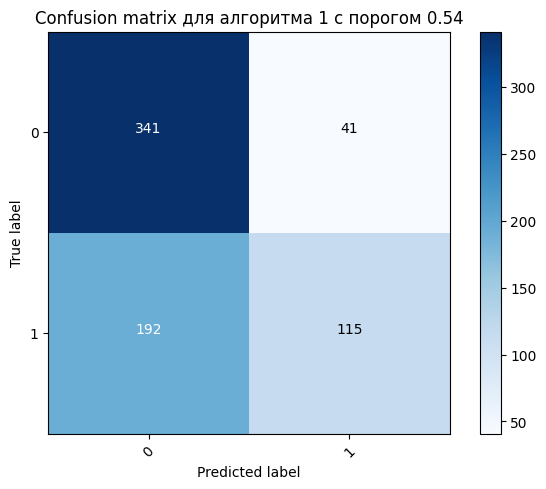

In [25]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew11})), set(y), title='Confusion matrix для алгоритма 1 c порогом 0.54')

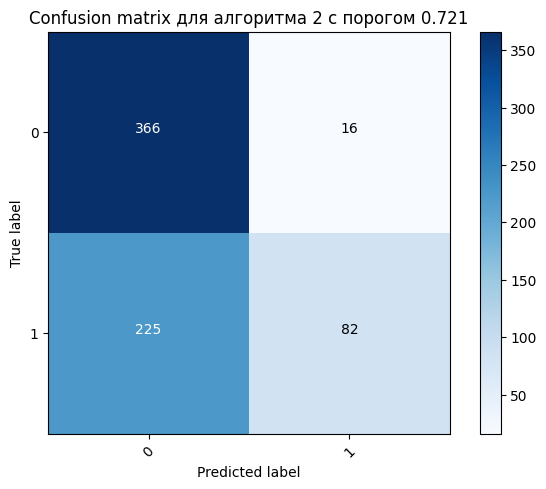

In [26]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew22})), set(y), title='Confusion matrix для алгоритма 2 c порогом 0.721')

Вывод: Начнём с 3 модели. Она не справилась с задачей совсем, так как при любом пороге Accuracy было меньше 0.65.

1 модель дала Precision = 0.737, тогда как модель номер 2 выдала Precision = 0.837, что больше, чем у первой. Это значит, что модель 2 лучше всех выполняет задачу минимизации выдачи кредитов тем людям, которые не смогут их вернуть.

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9. (0.5 балла)** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [27]:
y_newnew111 = []
f1 = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred1_probs"][j] > i:
            y_newnew111.append(1)
        else:
            y_newnew111.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew111})) < 0.65:
        f1.append(0)
        y_newnew111 = []
    else:
        f1.append(f1_score(y, pd.DataFrame({'': y_newnew111})))
        y_newnew111 = []
    i_list.append(i)

if np.max(f1) > 0:
    print(f'Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен {np.max(f1)}, '
      f'порог вероятности равен {i_list[f1.index(np.max(f1))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred1_probs"][j] > i_list[f1.index(np.max(f1))]:
        y_newnew111.append(1)
    else:
        y_newnew111.append(0)

Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен 0.6552217453505007, порог вероятности равен 0.359.


In [32]:
y_newnew222 = []
f1 = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred2_probs"][j] > i:
            y_newnew222.append(1)
        else:
            y_newnew222.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew222})) < 0.65:
        f1.append(0)
        y_newnew222 = []
    else:
        f1.append(f1_score(y, pd.DataFrame({'': y_newnew222})))
        y_newnew222 = []
    i_list.append(i)

if np.max(f1) > 0:
    print(f'Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен {np.max(f1)}, '
      f'порог вероятности равен {i_list[f1.index(np.max(f1))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred2_probs"][j] > i_list[f1.index(np.max(f1))]:
        y_newnew222.append(1)
    else:
        y_newnew222.append(0)

Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен 0.6990291262135923, порог вероятности равен 0.32.


In [28]:
y_newnew333 = []
f1 = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if X["pred3_probs"][j] > i:
            y_newnew333.append(1)
        else:
            y_newnew333.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew333})) < 0.65:
        f1.append(0)
        y_newnew333 = []
    else:
        f1.append(f1_score(y, pd.DataFrame({'': y_newnew333})))
        y_newnew333 = []
    i_list.append(i)

if np.max(f1) > 0:
    print(f'Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен {np.max(f1)}, '
      f'порог вероятности равен {i_list[f1.index(np.max(f1))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if X["pred3_probs"][j] > i_list[f1.index(np.max(f1))]:
        y_newnew333.append(1)
    else:
        y_newnew333.append(0)

Данная модель ни при каком шаге не даёт accuracy >= 0.65.


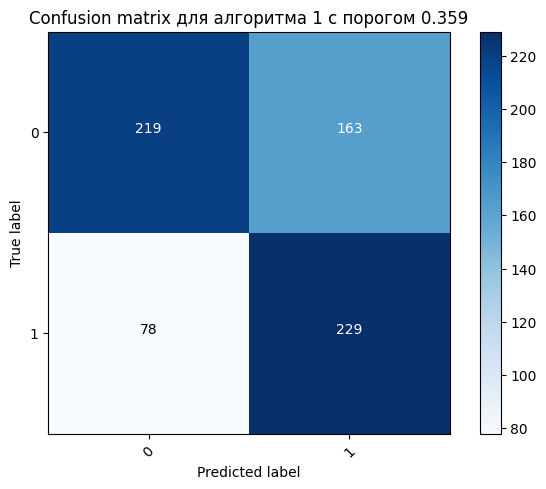

In [30]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew111})), set(y), title='Confusion matrix для алгоритма 1 c порогом 0.359')

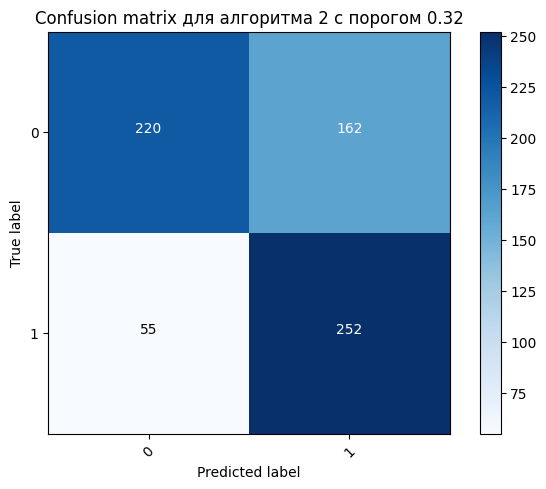

In [33]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew222})), set(y), title='Confusion matrix для алгоритма 2 c порогом 0.32')

Вывод: 3 модель оказалась совсем непригодна ни для одной из наших задач.

1 модель дала F1_score = 0.655, тогда как модель номер 2 выдала F1_score = 0.699, что больше, чем у первой. Это значит, что модель 2 лучше всех выполняет задачу минимизации выдачи кредитов тем людям, которые не смогут их вернуть и при это максимизации выдачи кредитов тем людям, которые смогут его вернуть. Для модели банка вполне может подойти именно F1_score.

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [29]:
from sklearn.metrics import classification_report

print(classification_report(df['target'], df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       382
           1       0.69      0.44      0.53       307

    accuracy                           0.66       689
   macro avg       0.67      0.64      0.63       689
weighted avg       0.67      0.66      0.65       689



### Обучим свою модель для предсказания target.

**Задание 10. (0.5 балла)** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [34]:
X_newnew = X.drop(['pred1_probs', 'pred1_classes', 'pred2_probs', 'pred2_classes', 'pred3_probs', 'pred3_classes'], axis=1, inplace=False)

In [35]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_newnew, y, test_size = 0.3)

In [37]:
lr_pipeline_new = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('logist_reg', LogisticRegression())
])

lr_pipe_params_new = {
    'logist_reg__C': [0.2],
    #'logist_reg__class_weight': ['balanced'],
    'logist_reg__penalty': ['l1'],
    'logist_reg__solver': ['saga'],
    'poly__degree': np.arange(2, 4, 1)
}

grid_lr_pipe_new = GridSearchCV(
    lr_pipeline_new,
    lr_pipe_params_new,
    cv=4,
    scoring='f1'
)

grid_lr_pipe_new.fit(X_train_, y_train_)

print(f'F1_score методом логистической регресси с наилучшими параметрами на train: {f1_score(y_train_, grid_lr_pipe_new.predict(X_train_))},')
print(f'F1_score методом логистической регресси с наилучшими параметрами на test: {f1_score(y_test_, grid_lr_pipe_new.predict(X_test_))},')
print(f'ROC AUC методом методом логистической регресси с подбором параметров: {roc_auc_score(y_test_, grid_lr_pipe_new.predict(X_test_))},')
print(f'Accuracy методом логистической регресси с подбором параметра полиномиальности: {accuracy_score(y_test_, grid_lr_pipe_new.predict(X_test_))}.')
print('Используемые гиперпараметры:', grid_lr_pipe_new.best_params_)

F1_score методом логистической регресси с наилучшими параметрами на train: 0.8436018957345972,
F1_score методом логистической регресси с наилучшими параметрами на test: 0.8342245989304814,
ROC AUC методом методом логистической регресси с подбором параметров: 0.8485219356053474,
Accuracy методом логистической регресси с подбором параметра полиномиальности: 0.8502415458937198.
Используемые гиперпараметры: {'logist_reg__C': 0.2, 'logist_reg__penalty': 'l1', 'logist_reg__solver': 'saga', 'poly__degree': 3}


**Задание 11. (0.5 балла)** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность
    б) полноту
    в) f1-score.
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [38]:
predicted_proba = grid_lr_pipe_new.predict_proba(X_newnew)

In [39]:
y_newnew1 = []
recall = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if predicted_proba[j][1] > i:
            y_newnew1.append(1)
        else:
            y_newnew1.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew1})) < 0.65:
        recall.append(0)
        y_newnew1 = []
    else:
        recall.append(recall_score(y, pd.DataFrame({'': y_newnew1})))
        y_newnew1 = []
    i_list.append(i)

if max(recall) > 0:
    print(f'Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен {max(recall)}, '
      f'порог вероятности равен {i_list[recall.index(max(recall))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if predicted_proba[j][1] > i_list[recall.index(max(recall))]:
        y_newnew1.append(1)
    else:
        y_newnew1.append(0)

Максимальный recall в подборе гиперпараметра порога с шагом 0.001 равен 0.9478827361563518, порог вероятности равен 0.495.


In [40]:
y_newnew11 = []
precision = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if predicted_proba[j][1] > i:
            y_newnew11.append(1)
        else:
            y_newnew11.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew11})) < 0.65:
        precision.append(0)
        y_newnew11 = []
    else:
        precision.append(precision_score(y, pd.DataFrame({'': y_newnew11})))
        y_newnew11 = []
    i_list.append(i)

if max(precision) > 0:
    print(f'Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен {max(precision)}, '
      f'порог вероятности равен {i_list[precision.index(max(precision))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if predicted_proba[j][1] > i_list[precision.index(max(precision))]:
        y_newnew11.append(1)
    else:
        y_newnew11.append(0)

Максимальный precision в подборе гиперпараметра порога с шагом 0.001 равен 0.9385964912280702, порог вероятности равен 0.51.


In [41]:
y_newnew111 = []
f1 = []
i_list = []
for i in np.arange(0, 1.001, 0.001):
    for j in range (689):
        if predicted_proba[j][1] > i:
            y_newnew111.append(1)
        else:
            y_newnew111.append(0)

    if accuracy_score(y, pd.DataFrame({'': y_newnew111})) < 0.65:
        f1.append(0)
        y_newnew111 = []
    else:
        f1.append(f1_score(y, pd.DataFrame({'': y_newnew111})))
        y_newnew111 = []
    i_list.append(i)

if max(f1) > 0:
    print(f'Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен {max(f1)}, '
      f'порог вероятности равен {i_list[f1.index(max(f1))]}.')
else:
    print('Данная модель ни при каком шаге не даёт accuracy >= 0.65.')

for j in range (689):
    if predicted_proba[j][1] > i_list[f1.index(max(f1))]:
        y_newnew111.append(1)
    else:
        y_newnew111.append(0)

Максимальный f1_score в подборе гиперпараметра порога с шагом 0.001 равен 0.8407224958949098, порог вероятности равен 0.5.


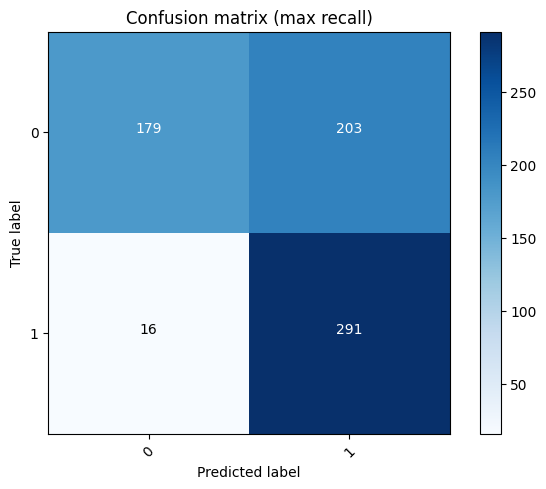

In [42]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew1})), set(y), title='Confusion matrix (max recall)')

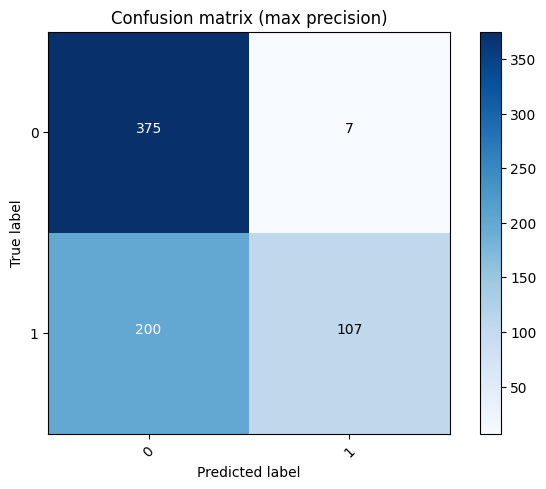

In [43]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew11})), set(y), title='Confusion matrix (max precision)')

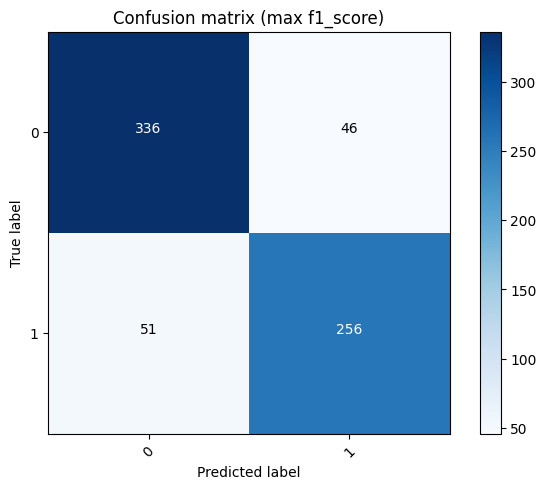

In [44]:
plot_confusion_matrix(confusion_matrix(y, pd.DataFrame({'': y_newnew111})), set(y), title='Confusion matrix (max f1_score)')

Для этой задачи лучше всего использовать модель логистической регрессии, чем модели, которые были даны в наборе данных.
Доминация логистической регрессии так же видна на матрице ошибок